In [1]:
import pandas as pd

# Load the data
combined = pd.read_csv("combined_cleaned.csv", index_col="Date", parse_dates=True)
returns = pd.read_csv("daily_returns.csv", index_col="Date", parse_dates=True)

# Check data
print(combined.head())
print(returns.head())


            Close_TSLA  High_TSLA   Low_TSLA  Open_TSLA  Volume_TSLA  \
Date                                                                   
2015-07-01   17.943333  18.174667  17.856667  18.073999   31518000.0   
2015-07-02   18.667999  18.830000  18.220667  18.680000  107458500.0   
2015-07-06   18.648001  18.779333  18.420000  18.591999   61828500.0   
2015-07-07   17.858667  18.346666  17.384666  18.333332   91576500.0   
2015-07-08   16.997334  17.386667  16.954000  17.288000   93316500.0   

            Close_BND   High_BND    Low_BND   Open_BND  Volume_BND  \
Date                                                                 
2015-07-01  60.816715  60.914441  60.764093  60.794164   5399300.0   
2015-07-02  60.967098  61.027240  60.937027  60.937027   1060100.0   
2015-07-06  61.177578  61.222687  61.057301  61.222687   2210700.0   
2015-07-07  61.237728  61.470769  61.237728  61.410634   4183200.0   
2015-07-08  61.410606  61.463229  61.312875  61.373017   1967800.0   

    

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Extract the target column (Tesla's close price)
tsla_close = combined['Close_TSLA'].values.reshape(-1, 1)

# Scale the data to 0-1 range
scaler = MinMaxScaler()
tsla_scaled = scaler.fit_transform(tsla_close)


In [4]:
import numpy as np

def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 60
X_all, y_all = create_sequences(tsla_scaled, sequence_length)

In [5]:
# Split index (e.g., up to end of 2023)
split_index = combined.loc[:'2023-12-31'].shape[0] - sequence_length

X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Single output

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0230 - val_loss: 0.0069
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0

In [8]:
# Predict
predicted_stock_price = model.predict(X_test)

# Invert scaling
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


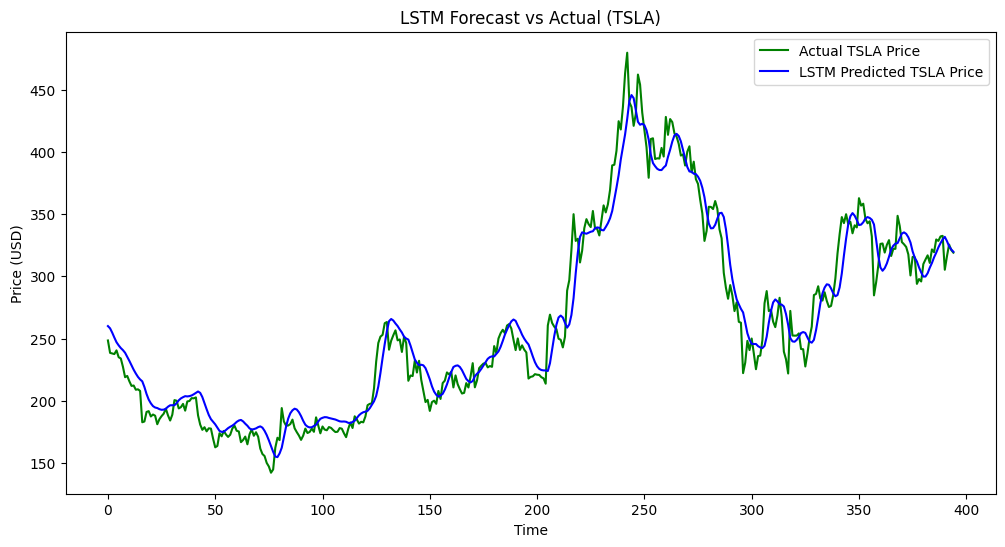

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(real_stock_price, color='green', label='Actual TSLA Price')
plt.plot(predicted_stock_price, color='blue', label='LSTM Predicted TSLA Price')
plt.title('LSTM Forecast vs Actual (TSLA)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_lstm = mean_absolute_error(real_stock_price, predicted_stock_price)
rmse_lstm = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
mape_lstm = np.mean(np.abs((real_stock_price - predicted_stock_price) / real_stock_price)) * 100

print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAPE: {mape_lstm:.2f}%")


LSTM MAE: 13.33
LSTM RMSE: 17.31
LSTM MAPE: 5.26%


In [13]:
model.save("lstm model.h5")
